In [1]:
import os
import sys

sys.path.append('../')


import warnings

warnings.filterwarnings("ignore")

import json
from pathlib import Path
from typing import Dict
import random

import click
import datasets
import numpy as np
import torch
import torch.nn.functional as F
import transformers
import yaml
from accelerate import Accelerator
from accelerate.utils import set_seed, tqdm
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import AdamW

from config_utils.load_config import (
    DataParamsSchema,
    ModelParamsSchema,
    TrainParamsSchema,
    load_params_from_yaml,
)

from model.model_main import MoETransformerEncoder
from train.train_utils.data import PrepareDataloader, PrepareDataset
from train.train_utils.gate import (
    process_gate_response,
    calculate_loss_accuracy,
    epoch_gates_cat,
)


from model.model_main import MoETransformerEncoder

import transformers

In [2]:
model_params = load_params_from_yaml("model_params.yaml", ModelParamsSchema)
loaded_params = load_params_from_yaml("dataset_params.yaml", DataParamsSchema)
train_params = load_params_from_yaml("train_params.yaml", TrainParamsSchema)


subreddit1_loaded = torch.load("../data/masked/programming.pt")
subreddit2_loaded = torch.load("../data/masked/gaming.pt")

In [3]:
dataset = PrepareDataset(
        subreddit1_loaded,
        subreddit2_loaded,
    )

programming_dataloader, gaming_dataloader = PrepareDataloader(dataset, train_params)

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 465
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [12]:
model = MoETransformerEncoder(**model_params.__dict__)
weights = torch.load("moe_model.pth",  map_location=torch.device('cpu'))
model.load_state_dict(weights)
model

MoETransformerEncoder(
  (input_emb): InputEmbedding(
    (input_embedding): Embedding(30522, 256)
    (positional_encoding): PositionalEncoding()
  )
  (moe_transformer): Sequential(
    (0): EncoderBlock(
      (multi_head_attention): MultiHeadAttention_Parallel(
        (key): Linear(in_features=256, out_features=4096, bias=False)
        (query): Linear(in_features=256, out_features=4096, bias=False)
        (value): Linear(in_features=256, out_features=4096, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=4096, out_features=256, bias=True)
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (moe_block): MoELayer(
        (gate): Linear(in_features=256, out_features=4, bias=False)
        (experts): ModuleList(
          (0-3): 4 x PositionwiseFeedForward(
            (linear1): Linear(in_features=256, out_features=512, bias=True)
            (linear2): Linear(in_features=512, out_features=256, bias=True)
 

In [13]:
device = torch.device("mps")
model = model.to(device)

In [15]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained(loaded_params.data_params.tokenizer_name)

In [74]:
model.eval()
with tqdm(
    desc="Eval", total=len(programming_dataloader), dynamic_ncols=True
) as eval_pbar:
    epoch_gates_stats_val = torch.tensor([]).to(model_params.device)
    with torch.no_grad():
        for eval_batch in programming_dataloader:
            input_ids, attention_mask, labels = (
                eval_batch["input_ids"].to(device),
                eval_batch["attention_mask"].to(device),
                eval_batch["labels"].to(device),
            )
            output, gate_respond_val = model(input_ids)

            # mask = (input_ids == 103)
            # masked_targets = torch.full_like(labels, -1, dtype=torch.long, device=device)
            # masked_targets[mask] = labels[mask]
            # masked_targets = masked_targets.view(-1)
            # output_ = output.view(-1, output.size(-1))
            # print(mask.shape, masked_targets.shape, output_.shape, loss)
            # loss = F.cross_entropy(output_, masked_targets, ignore_index=-1)

            # # Декодируем входные токены
            # decoded_inputs = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]
            # # Декодируем предсказанные токены
            # predicted_ids = torch.argmax(output.view(-1, output.size(-1)), dim=-1)  # Получаем предсказанные токены
            # predicted_ids = predicted_ids.view(-1, 64)  # Преобразуем обратно в [batch_size, max_len]
            # decoded_predictions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in predicted_ids]

            # print(decoded_predictions)
            # print(decoded_inputs)

            # print("-" * 40)

            # Выводим результаты
            # for i in range(len(decoded_inputs)):
            #     print(f"Input: {decoded_inputs[i]}")
            #     print(f"Predicted: {decoded_predictions[i]}")
            #     print("-" * 40)


            # mask = torch.full_like(labels, -1, device=device)
            # for i in range(labels.size(0)):
            #     index_eq = ((input_ids[i] == 103).int()).nonzero(as_tuple=True)[0] 
            #     mask[i, :index_eq + 1] = True
            #     masked_targets = labels.masked_fill(mask, 0)

            # print(masked_targets.shape)

            mask = input_ids == train_params.tokenizer_mask_id
            print(mask.shape)
            masked_output = output[mask]
            masked_labels = labels[mask]

            # print(masked_output.shape, masked_labels.shape, output.shape, labels.shape)

            loss = F.cross_entropy(masked_output, masked_labels)
            _, predicted = torch.max(masked_output, dim=-1)
            # print(predicted.shape, masked_labels.shape)
            # predicted_decoded, labels_decoded = tokenizer.decode(predicted), tokenizer.decode(masked_labels)

            predicted_decoded = [tokenizer.decode(tok) for tok in predicted]
            labels_decoded = [tokenizer.decode(tok) for tok in masked_labels]

            # for i in range(10):
            #     print("PRED", predicted_decoded[i], "REAL", labels_decoded[i])
            # # print(predicted_decoded)
            # # print(labels_decoded)
            # print("-" * 40)

            # print("BATCH", '\n\n')
            # for i in range(5):
            #     print("PRED", predicted_decoded[i], "REAL", labels_decoded[i])

            # print(predicted_decoded)
            # print(labels_decoded)
            # correct_predictions = (predicted == masked_labels).sum().item()
            # total_predictions = masked_labels.size(0)
            # accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0

            # # print(output.shape, gate_respond_val.shape)

            epoch_gates_stats_val = process_gate_response(
                epoch_gates_stats_val,
                gate_respond_val,
                train_params,
                model_params,
            )

            loss, accuracy = calculate_loss_accuracy(input_ids, output, labels, train_params)
            print(loss, accuracy)

            eval_pbar.update(1)

Eval:   7%|▋         | 1/15 [00:00<00:13,  1.06it/s]

torch.Size([32, 64])
tensor(5.3348, device='mps:0') 0.19112627986348124
torch.Size([32, 64])


Eval:  13%|█▎        | 2/15 [00:01<00:09,  1.34it/s]

tensor(5.7856, device='mps:0') 0.15579710144927536


Eval:  20%|██        | 3/15 [00:02<00:08,  1.48it/s]

torch.Size([32, 64])
tensor(5.3329, device='mps:0') 0.1828358208955224


Eval:  27%|██▋       | 4/15 [00:02<00:05,  1.95it/s]

torch.Size([32, 64])
tensor(5.6993, device='mps:0') 0.14982578397212543


Eval:  33%|███▎      | 5/15 [00:02<00:04,  2.27it/s]

torch.Size([32, 64])
tensor(5.4750, device='mps:0') 0.15555555555555556


Eval:  40%|████      | 6/15 [00:03<00:03,  2.52it/s]

torch.Size([32, 64])
tensor(5.5392, device='mps:0') 0.21305841924398625


Eval:  47%|████▋     | 7/15 [00:03<00:02,  2.79it/s]

torch.Size([32, 64])
tensor(5.5864, device='mps:0') 0.1634980988593156


Eval:  53%|█████▎    | 8/15 [00:03<00:02,  3.07it/s]

torch.Size([32, 64])
tensor(5.5172, device='mps:0') 0.18518518518518517


Eval:  60%|██████    | 9/15 [00:04<00:02,  2.74it/s]

torch.Size([32, 64])
tensor(5.2822, device='mps:0') 0.21660649819494585


Eval:  67%|██████▋   | 10/15 [00:04<00:01,  2.99it/s]

torch.Size([32, 64])
tensor(5.7603, device='mps:0') 0.14776632302405499
torch.Size([32, 64])


Eval:  73%|███████▎  | 11/15 [00:04<00:01,  2.28it/s]

tensor(5.6532, device='mps:0') 0.15384615384615385
torch.Size([32, 64])


Eval:  80%|████████  | 12/15 [00:05<00:01,  2.57it/s]

tensor(5.6027, device='mps:0') 0.174496644295302
torch.Size([32, 64])


Eval:  87%|████████▋ | 13/15 [00:05<00:00,  2.87it/s]

tensor(5.8274, device='mps:0') 0.1872791519434629
torch.Size([32, 64])


Eval:  93%|█████████▎| 14/15 [00:05<00:00,  3.06it/s]

tensor(5.5191, device='mps:0') 0.19413919413919414
torch.Size([17, 64])


Eval: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]

tensor(5.6105, device='mps:0') 0.14965986394557823


In [77]:
epoch_gates_stats_val.shape

torch.Size([45, 32, 64])

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

In [79]:
d = [int(i) for i in epoch_gates_stats_val.flatten().cpu()]

while -1 in d:
    d.remove(-1)

Text(0.5, 1.0, 'programming')

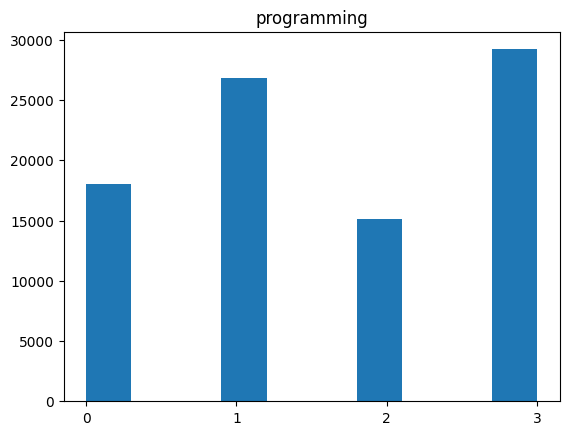

In [80]:
plt.hist(d)
plt.xticks(list(set(d)))
plt.title('programming')

In [82]:
epoch_gate_stats_val_1 = epoch_gates_stats_val[::3]
epoch_gate_stats_val_2 = epoch_gates_stats_val[1::3]
epoch_gate_stats_val_3 = epoch_gates_stats_val[2::3]

d1 = [int(i) for i in epoch_gate_stats_val_1.flatten().cpu()]

while -1 in d1:
    d1.remove(-1)

d2 = [int(i) for i in epoch_gate_stats_val_2.flatten().cpu()]

while -1 in d2:
    d2.remove(-1)

d3 = [int(i) for i in epoch_gate_stats_val_3.flatten().cpu()]

while -1 in d3:
    d3.remove(-1)

Text(0.5, 1.0, 'programming_1 block')

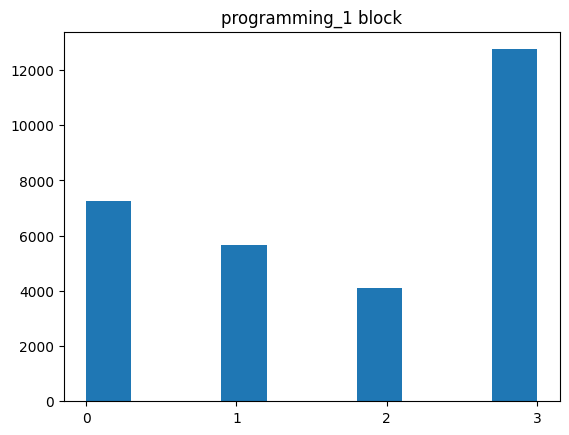

In [83]:
plt.hist(d1)
plt.xticks(list(set(d1)))
plt.title('programming_1 block')

Text(0.5, 1.0, 'programming_2 block')

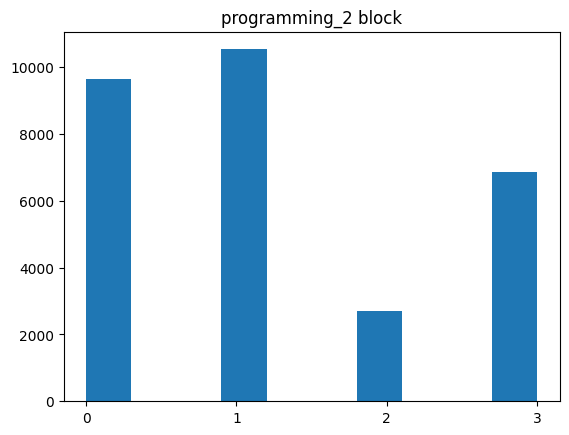

In [84]:
plt.hist(d2)
plt.xticks(list(set(d2)))
plt.title('programming_2 block')

Text(0.5, 1.0, 'programming_3 block')

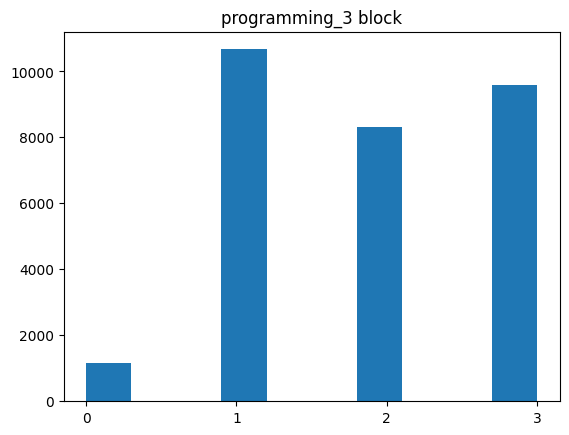

In [85]:
plt.hist(d3)
plt.xticks(list(set(d3)))
plt.title('programming_3 block')

In [86]:
model.eval()
with tqdm(
    desc="Eval", total=len(gaming_dataloader), dynamic_ncols=True
) as eval_pbar:
    epoch_gates_stats_val = torch.tensor([]).to(model_params.device)
    with torch.no_grad():
        for eval_batch in gaming_dataloader:
            input_ids, attention_mask, labels = (
                eval_batch["input_ids"].to(device),
                eval_batch["attention_mask"].to(device),
                eval_batch["labels"].to(device),
            )
            output, gate_respond_val = model(input_ids)

            # mask = (input_ids == 103)
            # masked_targets = torch.full_like(labels, -1, dtype=torch.long, device=device)
            # masked_targets[mask] = labels[mask]
            # masked_targets = masked_targets.view(-1)
            # output_ = output.view(-1, output.size(-1))
            # print(mask.shape, masked_targets.shape, output_.shape, loss)
            # loss = F.cross_entropy(output_, masked_targets, ignore_index=-1)

            # # Декодируем входные токены
            # decoded_inputs = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]
            # # Декодируем предсказанные токены
            # predicted_ids = torch.argmax(output.view(-1, output.size(-1)), dim=-1)  # Получаем предсказанные токены
            # predicted_ids = predicted_ids.view(-1, 64)  # Преобразуем обратно в [batch_size, max_len]
            # decoded_predictions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in predicted_ids]

            # print(decoded_predictions)
            # print(decoded_inputs)

            # print("-" * 40)

            # Выводим результаты
            # for i in range(len(decoded_inputs)):
            #     print(f"Input: {decoded_inputs[i]}")
            #     print(f"Predicted: {decoded_predictions[i]}")
            #     print("-" * 40)


            # mask = torch.full_like(labels, -1, device=device)
            # for i in range(labels.size(0)):
            #     index_eq = ((input_ids[i] == 103).int()).nonzero(as_tuple=True)[0] 
            #     mask[i, :index_eq + 1] = True
            #     masked_targets = labels.masked_fill(mask, 0)

            # print(masked_targets.shape)

            mask = input_ids == train_params.tokenizer_mask_id
            print(mask.shape)
            masked_output = output[mask]
            masked_labels = labels[mask]

            # print(masked_output.shape, masked_labels.shape, output.shape, labels.shape)

            loss = F.cross_entropy(masked_output, masked_labels)
            _, predicted = torch.max(masked_output, dim=-1)
            # print(predicted.shape, masked_labels.shape)
            # predicted_decoded, labels_decoded = tokenizer.decode(predicted), tokenizer.decode(masked_labels)

            predicted_decoded = [tokenizer.decode(tok) for tok in predicted]
            labels_decoded = [tokenizer.decode(tok) for tok in masked_labels]

            # for i in range(10):
            #     print("PRED", predicted_decoded[i], "REAL", labels_decoded[i])
            # # print(predicted_decoded)
            # # print(labels_decoded)
            # print("-" * 40)

            # print("BATCH", '\n\n')
            # for i in range(5):
            #     print("PRED", predicted_decoded[i], "REAL", labels_decoded[i])

            # print(predicted_decoded)
            # print(labels_decoded)
            # correct_predictions = (predicted == masked_labels).sum().item()
            # total_predictions = masked_labels.size(0)
            # accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0

            # # print(output.shape, gate_respond_val.shape)

            epoch_gates_stats_val = process_gate_response(
                epoch_gates_stats_val,
                gate_respond_val,
                train_params,
                model_params,
            )

            loss, accuracy = calculate_loss_accuracy(input_ids, output, labels, train_params)
            print(loss, accuracy)

            eval_pbar.update(1)

Eval:   3%|▎         | 1/32 [00:00<00:29,  1.05it/s]

torch.Size([32, 64])
tensor(5.4986, device='mps:0') 0.15953307392996108
torch.Size([32, 64])


Eval:   6%|▋         | 2/32 [00:01<00:22,  1.36it/s]

tensor(5.0358, device='mps:0') 0.20599250936329588
torch.Size([32, 64])


Eval:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

tensor(5.0199, device='mps:0') 0.17578125
torch.Size([32, 64])


Eval:  12%|█▎        | 4/32 [00:02<00:13,  2.13it/s]

tensor(5.4724, device='mps:0') 0.14388489208633093
torch.Size([32, 64])


Eval:  16%|█▌        | 5/32 [00:02<00:10,  2.52it/s]

tensor(5.6070, device='mps:0') 0.12222222222222222
torch.Size([32, 64])


Eval:  19%|█▉        | 6/32 [00:02<00:09,  2.82it/s]

tensor(5.6213, device='mps:0') 0.16296296296296298
torch.Size([32, 64])


Eval:  22%|██▏       | 7/32 [00:03<00:07,  3.13it/s]

tensor(5.5265, device='mps:0') 0.1736111111111111
torch.Size([32, 64])


Eval:  25%|██▌       | 8/32 [00:03<00:07,  3.38it/s]

tensor(5.5657, device='mps:0') 0.1643835616438356
torch.Size([32, 64])


Eval:  28%|██▊       | 9/32 [00:03<00:06,  3.46it/s]

tensor(5.6746, device='mps:0') 0.16730038022813687
torch.Size([32, 64])


Eval:  31%|███▏      | 10/32 [00:03<00:06,  3.62it/s]

tensor(5.7772, device='mps:0') 0.12915129151291513
torch.Size([32, 64])


Eval:  34%|███▍      | 11/32 [00:04<00:05,  3.79it/s]

tensor(5.2065, device='mps:0') 0.1708185053380783
torch.Size([32, 64])


Eval:  38%|███▊      | 12/32 [00:04<00:05,  3.80it/s]

tensor(5.3893, device='mps:0') 0.20072992700729927
torch.Size([32, 64])


Eval:  41%|████      | 13/32 [00:04<00:04,  3.85it/s]

tensor(5.2700, device='mps:0') 0.21160409556313994
torch.Size([32, 64])


Eval:  44%|████▍     | 14/32 [00:04<00:04,  4.07it/s]

tensor(5.7272, device='mps:0') 0.14606741573033707
torch.Size([32, 64])


Eval:  47%|████▋     | 15/32 [00:04<00:04,  4.06it/s]

tensor(5.8430, device='mps:0') 0.11969111969111969
torch.Size([32, 64])


Eval:  50%|█████     | 16/32 [00:05<00:05,  3.07it/s]

tensor(5.3185, device='mps:0') 0.1724137931034483
torch.Size([32, 64])


Eval:  53%|█████▎    | 17/32 [00:05<00:04,  3.23it/s]

tensor(5.4891, device='mps:0') 0.19935691318327975
torch.Size([32, 64])


Eval:  56%|█████▋    | 18/32 [00:06<00:04,  3.20it/s]

tensor(5.3092, device='mps:0') 0.1970260223048327
torch.Size([32, 64])


Eval:  59%|█████▉    | 19/32 [00:06<00:04,  3.21it/s]

tensor(5.5358, device='mps:0') 0.16129032258064516
torch.Size([32, 64])


Eval:  62%|██████▎   | 20/32 [00:06<00:03,  3.25it/s]

tensor(5.7090, device='mps:0') 0.13108614232209737
torch.Size([32, 64])


Eval:  66%|██████▌   | 21/32 [00:06<00:03,  3.32it/s]

tensor(5.1860, device='mps:0') 0.18181818181818182
torch.Size([32, 64])


Eval:  69%|██████▉   | 22/32 [00:07<00:03,  3.27it/s]

tensor(5.6661, device='mps:0') 0.16326530612244897
torch.Size([32, 64])


Eval:  72%|███████▏  | 23/32 [00:07<00:02,  3.41it/s]

tensor(5.3508, device='mps:0') 0.1444043321299639
torch.Size([32, 64])


Eval:  75%|███████▌  | 24/32 [00:07<00:02,  3.45it/s]

tensor(5.4235, device='mps:0') 0.17886178861788618
torch.Size([32, 64])


Eval:  78%|███████▊  | 25/32 [00:08<00:01,  3.53it/s]

tensor(5.3454, device='mps:0') 0.15037593984962405
torch.Size([32, 64])


Eval:  81%|████████▏ | 26/32 [00:08<00:01,  3.62it/s]

tensor(5.5572, device='mps:0') 0.15163934426229508
torch.Size([32, 64])


Eval:  84%|████████▍ | 27/32 [00:08<00:01,  3.51it/s]

tensor(5.5460, device='mps:0') 0.1553030303030303
torch.Size([32, 64])


Eval:  88%|████████▊ | 28/32 [00:08<00:01,  3.42it/s]

tensor(4.7595, device='mps:0') 0.1867704280155642
torch.Size([32, 64])


Eval:  91%|█████████ | 29/32 [00:09<00:00,  3.30it/s]

tensor(5.4188, device='mps:0') 0.1895910780669145
torch.Size([32, 64])


Eval:  94%|█████████▍| 30/32 [00:09<00:00,  3.28it/s]

tensor(5.2673, device='mps:0') 0.1970260223048327
torch.Size([32, 64])


Eval:  97%|█████████▋| 31/32 [00:09<00:00,  3.38it/s]

tensor(5.4302, device='mps:0') 0.19318181818181818
torch.Size([8, 64])


Eval: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]

tensor(5.0761, device='mps:0') 0.22580645161290322


In [87]:
epoch_gates_stats_val.shape

torch.Size([96, 32, 64])

In [88]:
d = [int(i) for i in epoch_gates_stats_val.flatten().cpu()]

while -1 in d:
    d.remove(-1)

Text(0.5, 1.0, 'gaming')

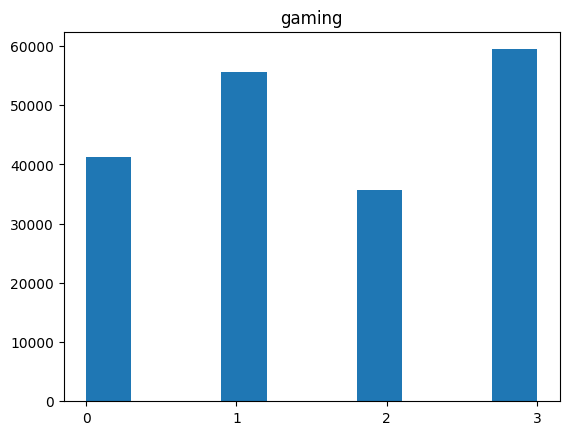

In [89]:
plt.hist(d)
plt.xticks(list(set(d)))
plt.title('gaming')

In [90]:
epoch_gate_stats_val_1 = epoch_gates_stats_val[::3]
epoch_gate_stats_val_2 = epoch_gates_stats_val[1::3]
epoch_gate_stats_val_3 = epoch_gates_stats_val[2::3]

d1 = [int(i) for i in epoch_gate_stats_val_1.flatten().cpu()]

while -1 in d1:
    d1.remove(-1)

d2 = [int(i) for i in epoch_gate_stats_val_2.flatten().cpu()]

while -1 in d2:
    d2.remove(-1)

d3 = [int(i) for i in epoch_gate_stats_val_3.flatten().cpu()]

while -1 in d3:
    d3.remove(-1)

Text(0.5, 1.0, 'gaming_1 block')

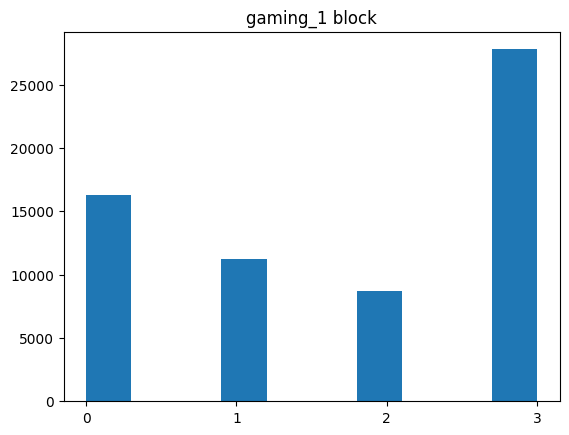

In [91]:
plt.hist(d1)
plt.xticks(list(set(d1)))
plt.title('gaming_1 block')

Text(0.5, 1.0, 'gaming_2 block')

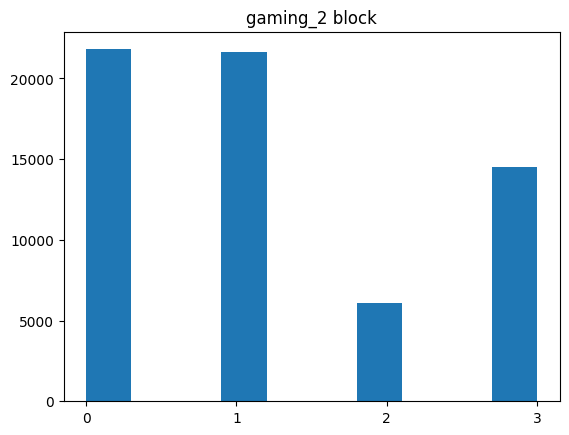

In [92]:
plt.hist(d2)
plt.xticks(list(set(d2)))
plt.title('gaming_2 block')

Text(0.5, 1.0, 'gaming_3 block')

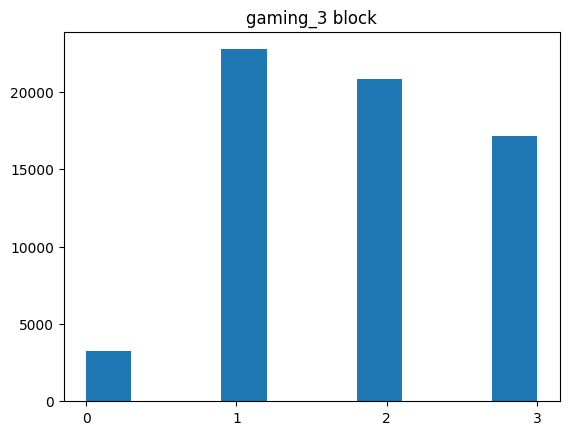

In [93]:
plt.hist(d3)
plt.xticks(list(set(d3)))
plt.title('gaming_3 block')